In [ ]:
%matplotlib inline
import os, glob
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
import os

# Create a directory to unzip the dataset
os.makedirs("gtsrb-german-traffic-sign", exist_ok=True)

# Unzip the dataset into the directory
with zipfile.ZipFile("gtsrb-german-traffic-sign.zip", 'r') as zip_ref:
    zip_ref.extractall("gtsrb-german-traffic-sign")


In [ ]:
data_path = 'gtsrb-german-traffic-sign'
train_path = 'gtsrb-german-traffic-sign/Train/'
test_path = 'gtsrb-german-traffic-signTest/'
df_meta = pd.read_csv('gtsrb-german-traffic-sign/Meta.csv')
df_train = pd.read_csv('gtsrb-german-traffic-sign/Train.csv')
df_test = pd.read_csv('gtsrb-german-traffic-sign/Test.csv')

In [ ]:
df_meta.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [ ]:
print("Min. Class Label: {}".format(df_meta.ClassId.min()))
print("Max Class Label: {}".format(df_meta.ClassId.max()))
print("Total Class Labels: {}".format(len(df_meta.ClassId.unique())))

Min. Class Label: 0
Max Class Label: 42
Total Class Labels: 43


In [ ]:
num_classes = len(df_meta.ClassId.unique())
class_dict = {}
class_labels = list(range(num_classes))
# Speed Class 0-9
speed_class = ['Speed Limit ' + item for item in [speed + ' kmph' for speed in ['20', '30', '50', '60', '70', '80']]]\
            + ['End of Speed Limit 80 kmph']
speed_class+= ['Speed Limit ' + item for item in [speed + ' kmph' for speed in ['100', '120']]]
speed_class
# 10, 11 No Passing
no_pass = ['No Passing' + item for item in ['', ' vehicle over 3.5 ton']]
# 12-43
rest = ['Right-of-way at intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Veh > 3.5 tons prohibited',\
            'No entry', 'General caution', 'Dangerous curve left', 'Dangerous curve right', 'Double curve', 'Bumpy road',
            'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing',
            'Bicycles crossing', 'Beware of ice/snow','Wild animals crossing', 'End speed + passing limits', 'Turn right ahead',
            'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left',
            'Roundabout mandatory', 'End of no passing', 'End no passing vehicle > 3.5 tons']
class_values = speed_class + no_pass + rest
class_dict = {keys:values for keys,values in zip(class_labels, class_values)}

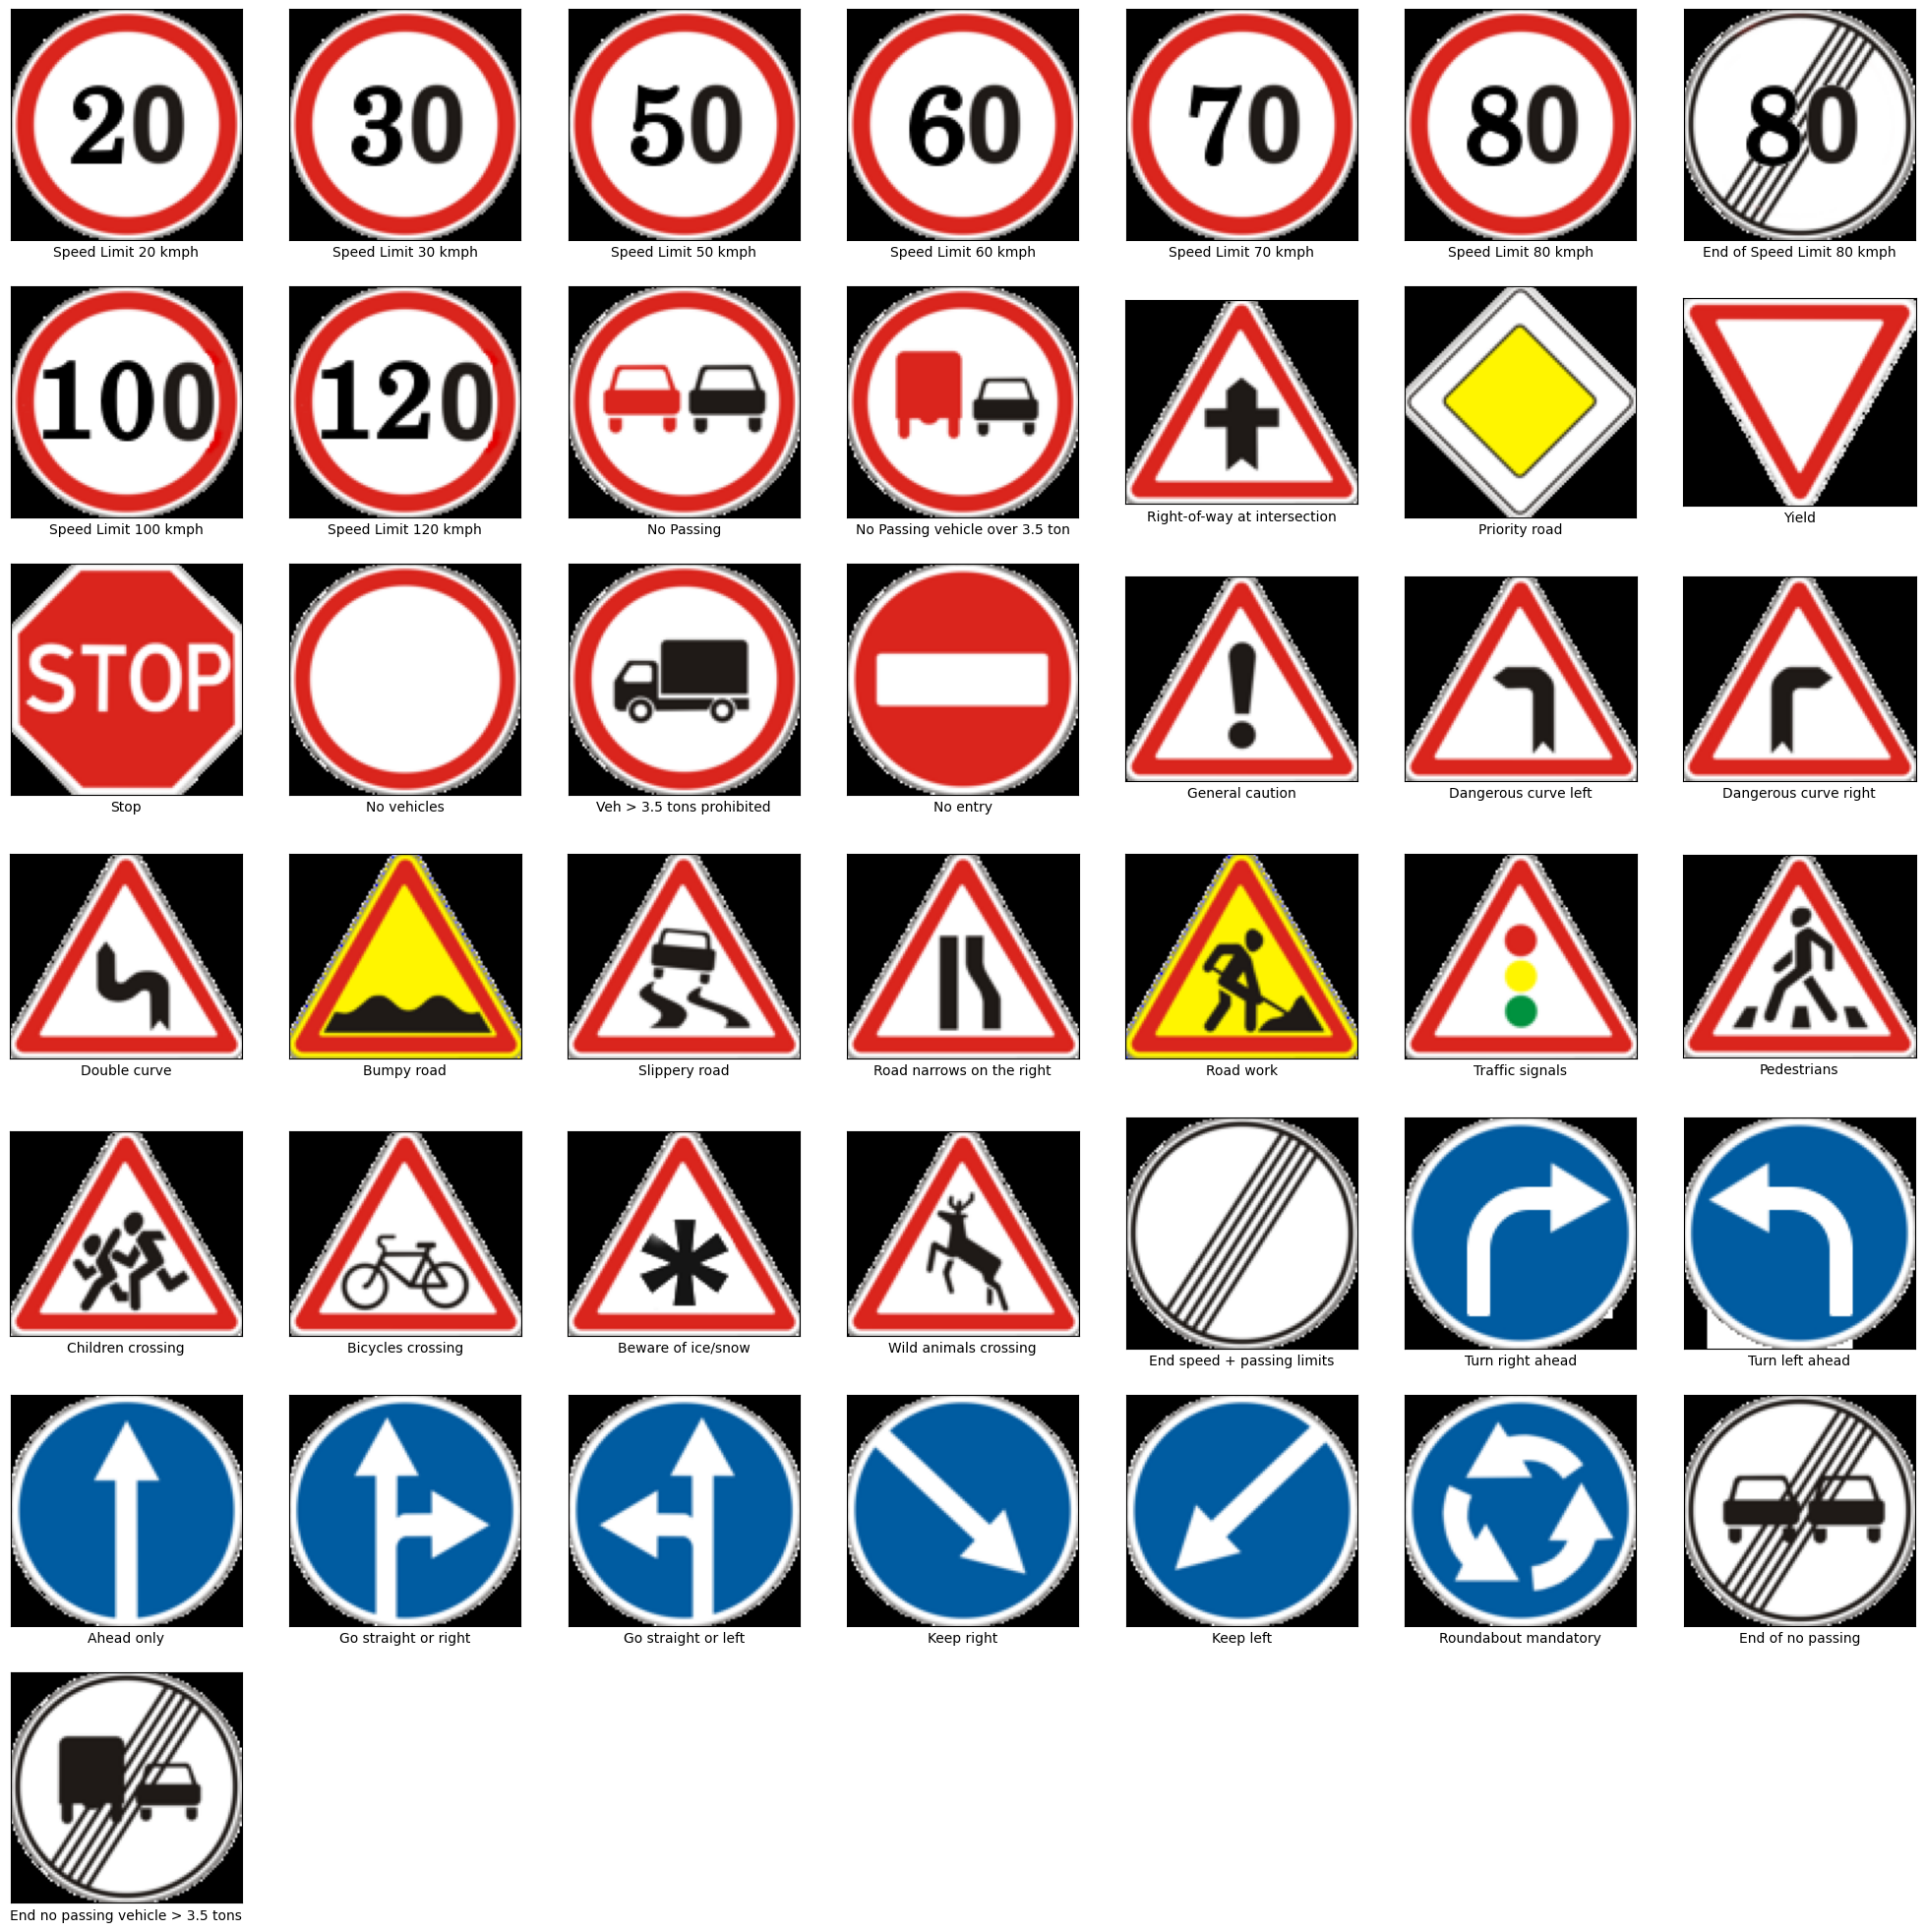

In [ ]:
sortFunction = lambda x: int(os.path.basename(x)[:-4])
plt.figure(figsize = (25, 25))
for i, imagename in enumerate(sorted(glob.glob('gtsrb-german-traffic-sign/Meta/' + '*.*'), key = sortFunction)):
    plt.subplot(7, 7, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_dict[i])
    image = cv2.imread(imagename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
shape_dict = {0: 'Triangle', 1: 'Circle', 2: 'Diamond', 3: 'Hexagon', 4: 'Inverse Triangle'}
df_meta.ShapeId.value_counts()

ShapeId
1    25
0    15
2     1
4     1
3     1
Name: count, dtype: int64

In [ ]:
def visualize_shape(shape = 0):
    """
    Plots random samples of a particular shape from shape_dict
    """
    filenames = df_meta[df_meta.ShapeId==shape].sample(10).Path
    plt.figure(figsize = (25, 25))
    for i, filename in enumerate(data_path + filenames):
        image = cv2.imread(filename)
        plt.subplot(11, 4, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

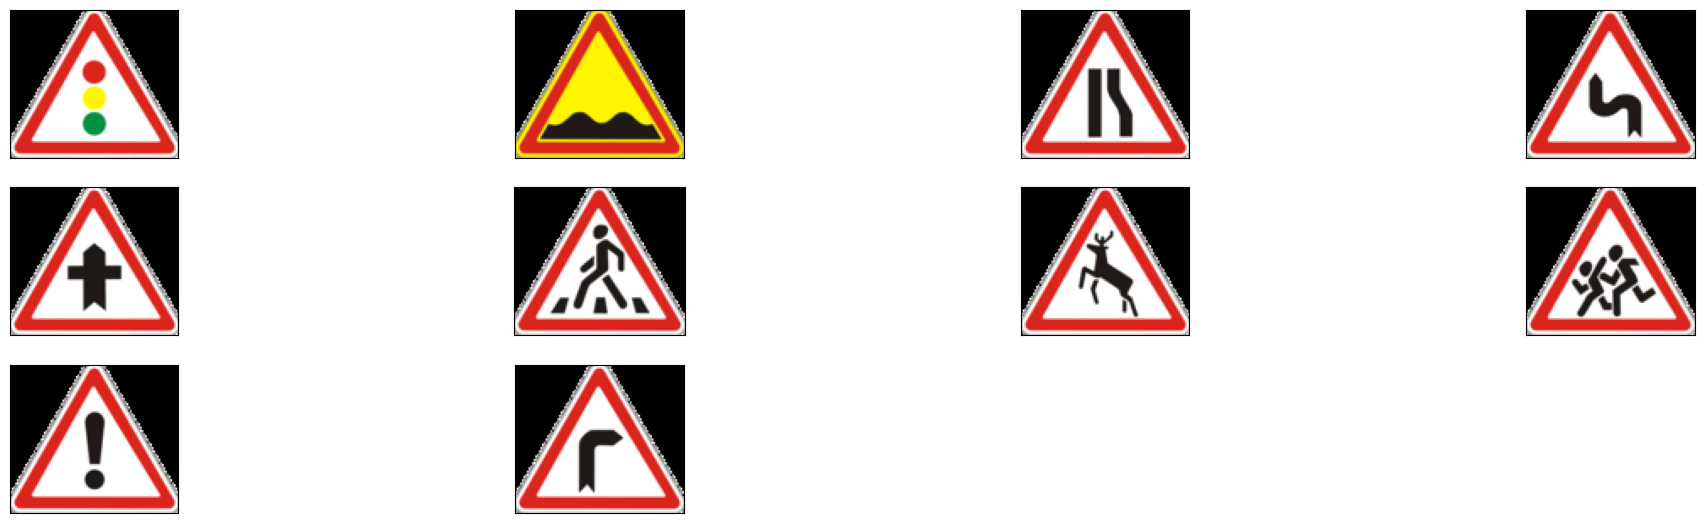

In [ ]:
# Visualize Triangular signs, ShapeId=0
visualize_shape(0)

In [ ]:
color_dict = {0:'Red', 1:'Blue', 2:'Yellow', 3:'White'}
df_meta.ColorId.value_counts()

ColorId
0    30
1     8
3     4
2     1
Name: count, dtype: int64

In [ ]:
def visualize_color(color = 0):
    """
    Plots random samples of a particular color from color_dict
    """
    filenames = df_meta[df_meta.ColorId==color].sample(5).Path
    plt.figure(figsize = (20, 20))
    for i, filename in enumerate(data_path + filenames):
        image = cv2.imread(filename)
        plt.subplot(1, 6, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

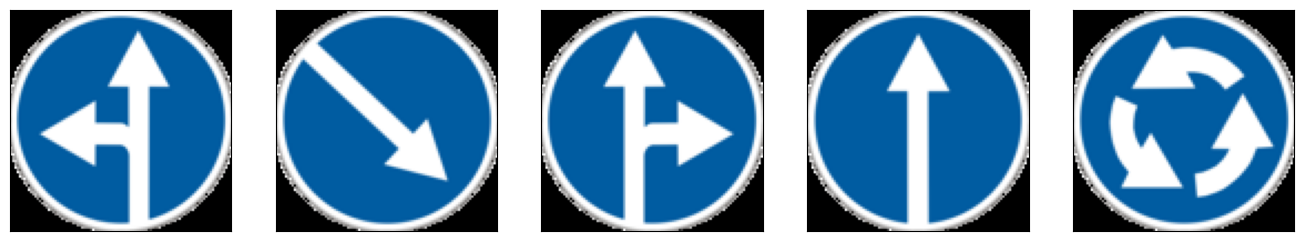

In [ ]:
# Visualize Blue Colored Traffic Signs, color = 1
visualize_color(color = 1)

In [ ]:
df_train.shape

(39209, 8)

In [ ]:
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [ ]:
df_train.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [ ]:
df_train.ClassId.value_counts()

ClassId
2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
3     1410
8     1410
11    1320
18    1200
35    1200
17    1110
14     780
31     780
33     689
15     630
26     600
28     540
23     510
30     450
16     420
6      420
34     420
22     390
36     390
40     360
20     360
21     330
39     300
29     270
24     270
32     240
27     240
41     240
42     240
37     210
0      210
19     210
Name: count, dtype: int64

In [ ]:
# Create a dictionary which consists of the labels as keys and the number of samples as values
train_dict = {}
train_dict = {keys:values for keys,values in zip(df_train.ClassId.value_counts().index, df_train.ClassId.value_counts().tolist())}

Text(0.5, 1.0, 'Class Distribution for Training data')

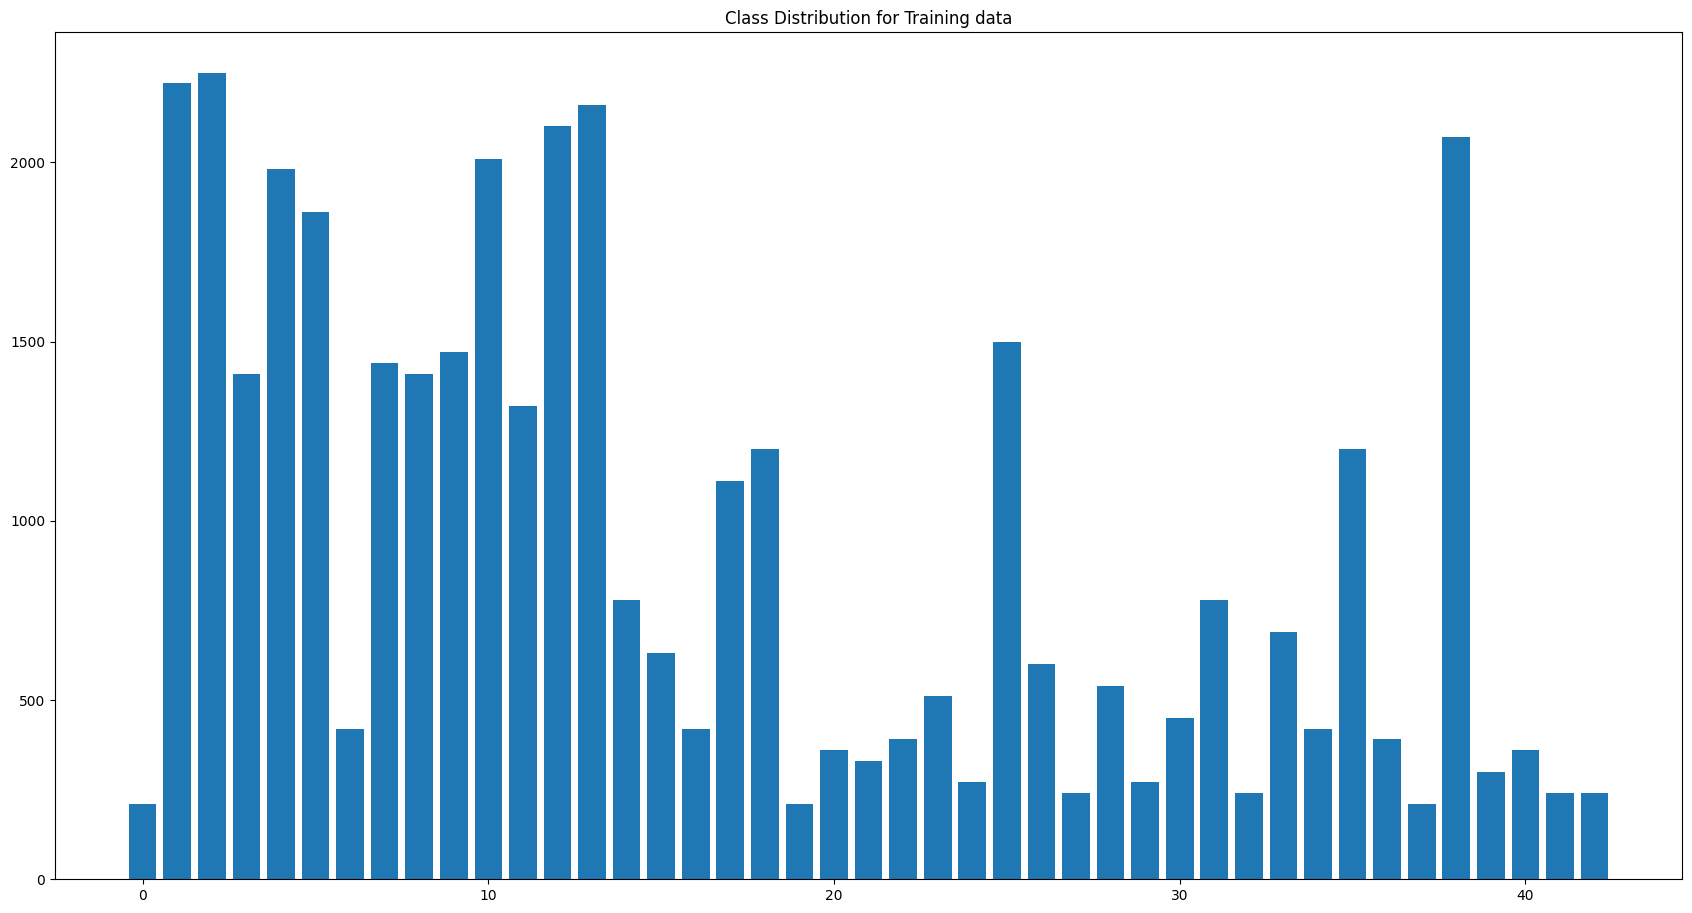

In [ ]:
plt.figure(figsize = (21 ,11))
plt.bar(train_dict.keys(), train_dict.values())
plt.title('Class Distribution for Training data')

In [ ]:
# Check the dataframe information with folder directory
train_folders = os.listdir(train_path)
# Create a dict with keys as label names and the number of images present inside each label folder as values
sample_dict = {}
for folders in train_folders:
    images = os.listdir(train_path + folders)
    sample_dict[folders] = len(images)
train_sample_dict = {int(k):v for k,v in zip(sample_dict.keys(), sample_dict.values())}
train_dict==train_sample_dict

True

In [ ]:

df_test.shape

(12630, 8)

In [ ]:
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [ ]:
df_test.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,50.507759,50.364450,5.998021,5.982423,44.864450,44.758116,15.551069
std,25.088483,23.698908,1.543954,1.427424,23.776102,22.494697,11.947123
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,57.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000


In [ ]:

df_test.ClassId.value_counts()

ClassId
2     750
1     720
13    720
38    690
12    690
4     660
10    660
5     630
9     480
25    480
3     450
8     450
7     450
11    420
35    390
18    390
17    360
31    270
14    270
15    210
33    210
26    180
30    150
16    150
28    150
6     150
23    150
22    120
36    120
34    120
24     90
29     90
20     90
40     90
21     90
39     90
42     90
32     60
27     60
41     60
19     60
0      60
37     60
Name: count, dtype: int64

In [ ]:
# Create a test_dict with keys as the labels and values as the value_counts
test_dict = {}
test_dict = {keys:values for keys,values in zip(df_test.ClassId.value_counts().index, df_test.ClassId.value_counts().tolist())}

Text(0.5, 1.0, 'Class Distribution of Test Data')

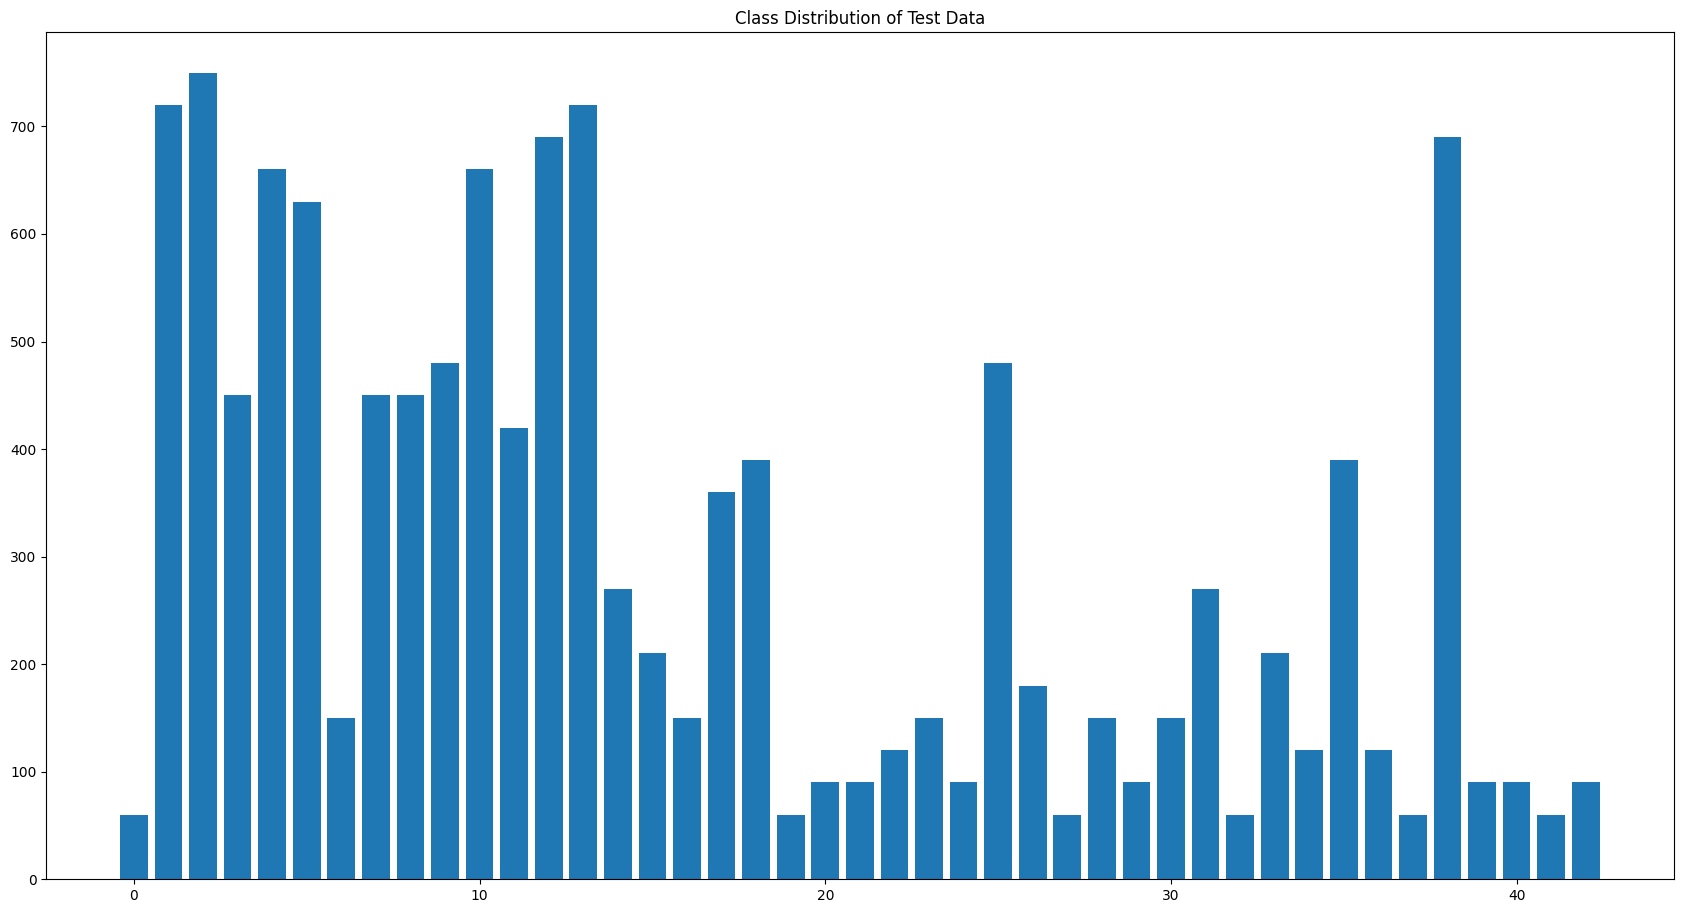

In [ ]:
plt.figure(figsize = (21, 11))
plt.bar(test_dict.keys(), test_dict.values())
plt.title("Class Distribution of Test Data")

In [ ]:
df_balance = pd.DataFrame()
df_balance['labels'] = list(range(43))
df_balance['train'] = train_dict.values()
df_balance['test'] = test_dict.values()
df_balance['total'] = df_balance['train'] + df_balance['test']
df_balance['train_ratio'] = df_balance['train']/df_balance['total']
df_balance['test_ratio'] = df_balance['test']/df_balance['total']

In [ ]:
df_balance.head(10)

,labels,train,test,total,train_ratio,test_ratio
0,0,2250,750,3000,0.750000,0.250000
1,1,2220,720,2940,0.755102,0.244898
2,2,2160,720,2880,0.750000,0.250000
3,3,2100,690,2790,0.752688,0.247312
4,4,2070,690,2760,0.750000,0.250000
5,5,2010,660,2670,0.752809,0.247191
6,6,1980,660,2640,0.750000,0.250000
7,7,1860,630,2490,0.746988,0.253012
8,8,1500,480,1980,0.757576,0.242424
9,9,1470,480,1950,0.753846,0.246154


<Axes: title={'center': 'Train Test Ratio for each class'}, xlabel='labels'>

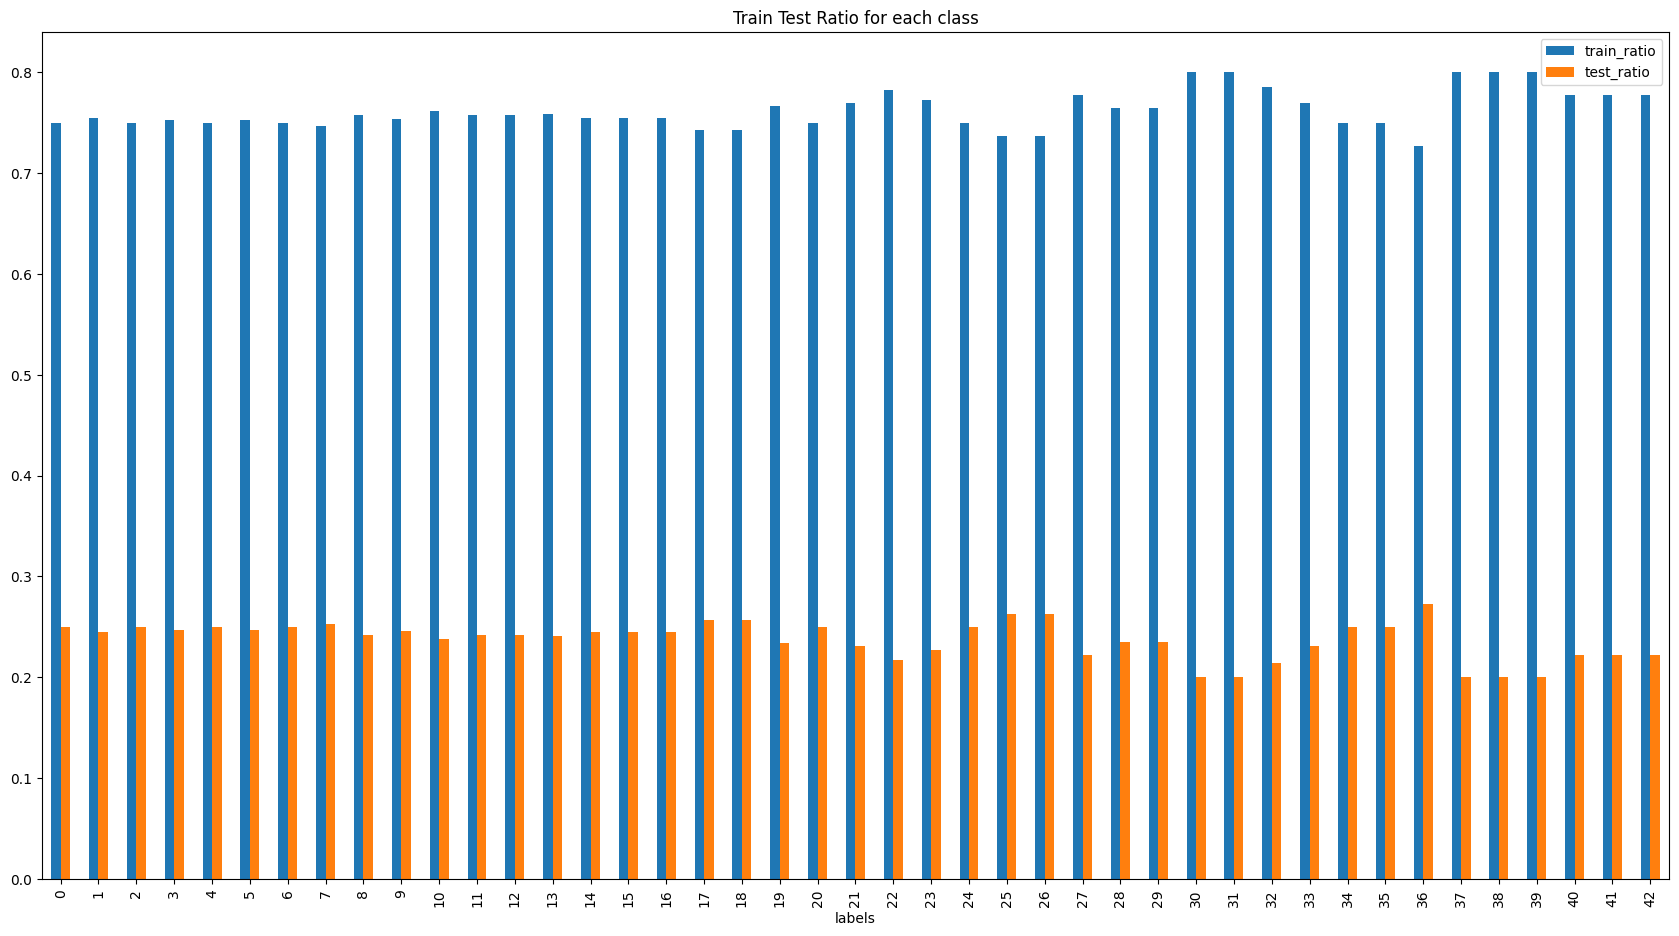

In [ ]:
df_balance.plot(x = 'labels', y = ['train_ratio', 'test_ratio'], kind = 'bar', figsize = (21, 11), title = "Train Test Ratio for each class")

In [ ]:
df_train.Path.duplicated().unique()

array([False])

In [ ]:
df_test.Path.duplicated().unique()

array([False])

In [ ]:
train_data = []
train_labels = []
for folders in tqdm.tqdm(train_folders):
    imagefiles = os.listdir(train_path + folders)
    for imagefile in imagefiles:
        path = os.path.join(train_path, folders, imagefile)
        image = Image.open(path)
        image = image.resize((32, 32))
        image = np.array(image)
        train_data.append(image)
        train_labels.append(int(folders))

100%|██████████| 43/43 [00:36<00:00,  1.18it/s]


In [ ]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)

In [ ]:
# Check the length of both arrays
len(df_train), len(train_data), len(train_labels)

(39209, 39209, 39209)

In [ ]:
print("There are {} images in train dataset".format(len(train_data)))
print("Each image has a dimension of : {}".format(train_data[0].shape))

There are 39209 images in train dataset
Each image has a dimension of : (32, 32, 3)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size = 0.2, stratify = train_labels, random_state = 42)
train_unique, y_train_count = np.unique(y_train, return_counts = True)
val_unique, y_val_count = np.unique(y_val, return_counts = True)
y_train, y_val = to_categorical(y_train, num_classes), to_categorical(y_val, num_classes)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(31367, 32, 32, 3) (31367, 43) (7842, 32, 32, 3) (7842, 43)


Text(0.5, 1.0, 'After Splitting into Train and Val')

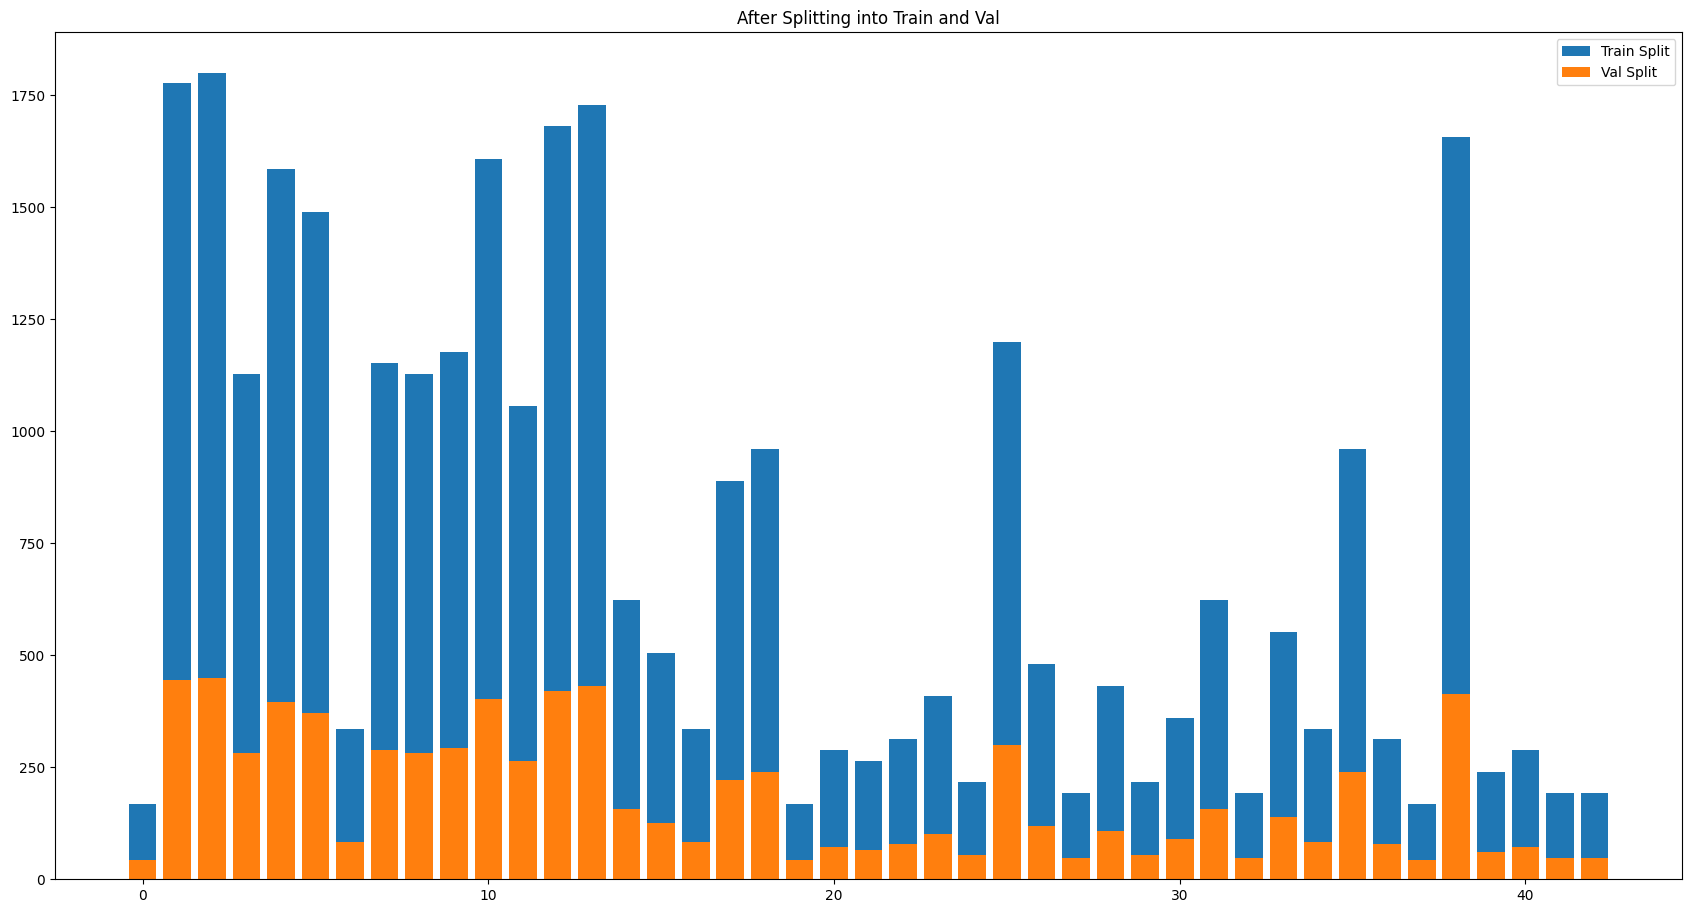

In [ ]:
plt.figure(figsize = (21, 11))
plt.bar(train_unique, y_train_count)
plt.bar(val_unique, y_val_count)
plt.legend(['Train Split', 'Val Split'], loc = 'upper right')
plt.title("After Splitting into Train and Val")

In [ ]:
test_data = []
test_ground_truth = df_test.ClassId.tolist()
test_filenames = (data_path + df_test.Path).tolist()
for test_filename in tqdm.tqdm(test_filenames):
    image_filename = Image.open(test_filename)
    image = image_filename.resize((32, 32))
    image = np.array(image)
    test_data.append(image)

100%|██████████| 12630/12630 [00:07<00:00, 1628.92it/s]


In [ ]:
X_test = np.array(test_data)
y_test = np.array(test_ground_truth)

In [ ]:
test_unique, y_test_count = np.unique(y_test, return_counts = True)

In [ ]:
df_balance['val'] = y_val_count
df_balance['val_ratio'] = df_balance['val']/df_balance['total']
df_balance['train_ratio'] = df_balance['train_ratio'] - df_balance['val_ratio']
df_balance.head()

,labels,train,test,total,train_ratio,test_ratio,val,val_ratio
0,0,2250,750,3000,0.736000,0.250000,42,0.014000
1,1,2220,720,2940,0.604082,0.244898,444,0.151020
2,2,2160,720,2880,0.593750,0.250000,450,0.156250
3,3,2100,690,2790,0.651613,0.247312,282,0.101075
4,4,2070,690,2760,0.606522,0.250000,396,0.143478


<Axes: title={'center': 'Train Val Test Split'}, xlabel='labels'>

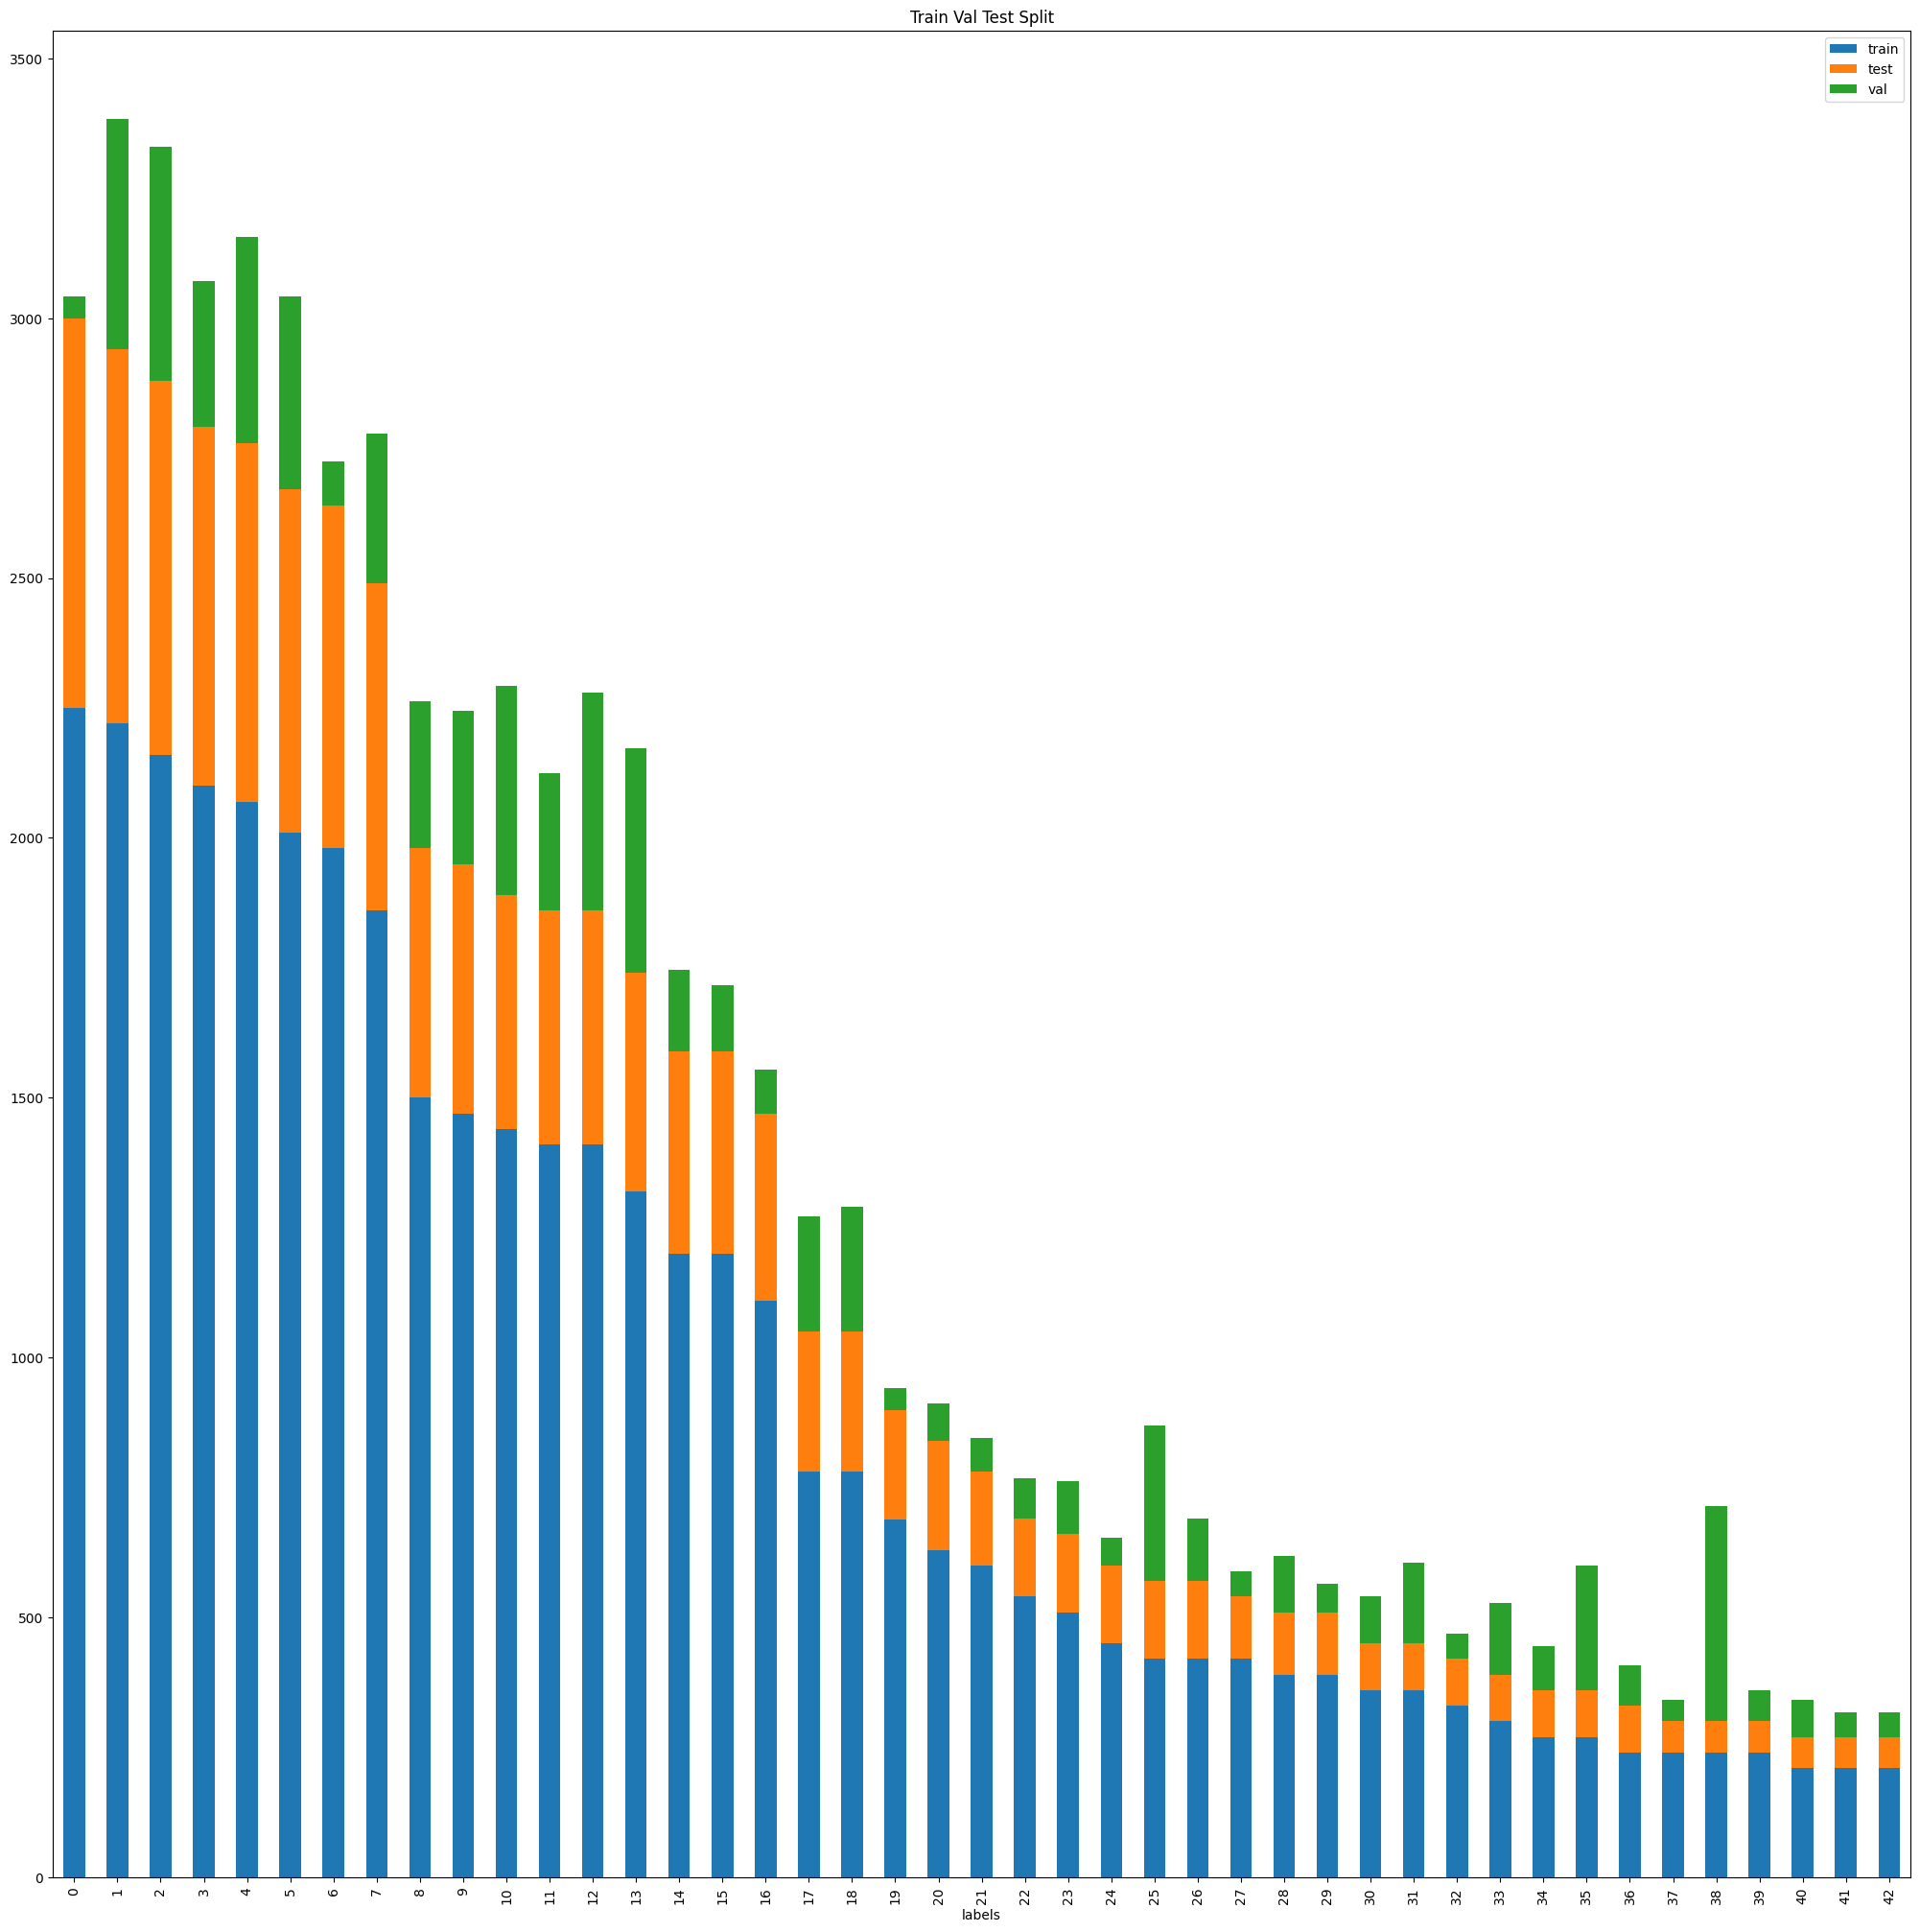

In [ ]:
df_balance.plot.bar(x = 'labels', y = ['train', 'test', 'val'], figsize = (25, 25), stacked = True, title = "Train Val Test Split")

In [ ]:
def get_compiled_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
X_train, X_val, X_test = X_train/255., X_val/255., X_test/255.

In [ ]:
model = get_compiled_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), verbose = True)

Epoch 1/20
981/981 [==============================] - 184s 186ms/step - loss: 1.1689 - accuracy: 0.6670 - val_loss: 0.1291 - val_accuracy: 0.9658
Epoch 2/20
981/981 [==============================] - 150s 153ms/step - loss: 0.1975 - accuracy: 0.9415 - val_loss: 0.0458 - val_accuracy: 0.9879
Epoch 3/20
981/981 [==============================] - 149s 152ms/step - loss: 0.1131 - accuracy: 0.9663 - val_loss: 0.0266 - val_accuracy: 0.9922
Epoch 4/20
981/981 [==============================] - 153s 156ms/step - loss: 0.0906 - accuracy: 0.9733 - val_loss: 0.0330 - val_accuracy: 0.9922
Epoch 5/20
981/981 [==============================] - 151s 154ms/step - loss: 0.0733 - accuracy: 0.9779 - val_loss: 0.0173 - val_accuracy: 0.9953
Epoch 6/20
981/981 [==============================] - 149s 152ms/step - loss: 0.0609 - accuracy: 0.9816 - val_loss: 0.0193 - val_accuracy: 0.9945
Epoch 7/20
981/981 [==============================] - 146s 149ms/step - loss: 0.0576 - accuracy: 0.9829 - val_loss: 0.0290 -

In [ ]:
plt.figure()
plt.plot(history.history['acc'], label = "Training Accuracy")
plt.plot(history.history['val_acc'], label = "Validation Accuracy")
plt.title("Accuracy Plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

KeyError: 'acc'

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.title("Loss Plot")
plt.xlabel("Epochs")
plt.ylabel("Loss (%)")
plt.legend()
plt.show()

In [ ]:
predictions = model.predict_classes(X_test)

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
cfm = confusion_matrix(y_test, predictions)

In [ ]:

accuracy_score(y_test, predictions)

In [ ]:
df_cfm = pd.DataFrame(cfm, index = [i for i in range(num_classes)], columns = [i for i in range(num_classes)])
plt.figure(figsize = (25, 25))
sns.heatmap(df_cfm, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))

In [ ]:
plt.figure(figsize = (30, 30))
start_index = 36
for i in range(30):
    plt.subplot(10, 3, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = predictions[start_index + i]
    ground_truth = y_test[start_index + i]
    col = 'g'
    if prediction != ground_truth:
        col = 'r'
    plt.xlabel('Actual Class {} , Predicted Class {}'.format(class_dict[ground_truth], class_dict[prediction]), color = col, weight = 'bold')
    plt.imshow(X_test[start_index + i])
plt.show()

In [ ]:
# Save the model for further implementation
os.mkdir('models')
model.save('models/traffic_sign_detection_gtsrb.h5')